In [ ]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
n_samples = 100
n_clusters = 3
centers = [(-5, -5), (0, 0), (5, 5)]
cluster_std = 0.5

# Generate points for each cluster
points = []
labels = []

for i, center in enumerate(centers):
    x = np.random.normal(center[0], cluster_std, n_samples // n_clusters)
    y = np.random.normal(center[1], cluster_std, n_samples // n_clusters)
    cluster_points = np.column_stack((x, y))
    points.append(cluster_points)
    labels.append(np.full(n_samples // n_clusters, i))

points = np.vstack(points)
labels = np.concatenate(labels)

df = pd.DataFrame(points, columns=['Feature1', 'Feature2'])
df['Label'] = labels
df_sorted = df.sort_values(by=['Feature1', 'Feature2']).reset_index(drop=True)

X = df_sorted[['Feature1', 'Feature2']].values
GT = df_sorted['Label'].values

plt.scatter(X[:, 0], X[:, 1], c=GT, cmap='viridis')
plt.title('Generated and Sorted Points')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()

scipy.io.savemat('data.mat', {'X': X, 'GT': GT})


grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(f'p.shape: {p.shape}')

graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep, log_scale=False):
    if log_scale:
        timestep = np.log10(timestep)
    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at log10(t)={timestep:.2f}' if log_scale else f'Diffusion Distance Matrix at t={timestep}')
    plt.show()
    
# for timestep in [10, 40, 80, 100]:
#     print(f"Plotting for log10(t)={np.log10(timestep):.2f}")
#     plot_diffusion_distance(G, timestep, log_scale=False)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 150, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

print(f'GT shape; {GT.shape}')
accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")
# plot_kde_density(X, "KDE Density Estimation")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data for the dumbbell
# Top cluster
top_cluster = np.column_stack((np.random.normal(loc=0, scale=0.1, size=100), 
                               np.random.normal(loc=1, scale=0.1, size=100)))
# Bottom cluster
bottom_cluster = np.column_stack((np.random.normal(loc=0, scale=0.1, size=100), 
                                  np.random.normal(loc=-1, scale=0.1, size=100)))
# Handle
handle = np.column_stack((np.random.normal(loc=0, scale=0.05, size=200), 
                          np.random.uniform(low=-1, high=1, size=200)))

# Combine all parts
X = np.vstack((top_cluster, bottom_cluster, handle))
labels = np.array([0]*100 + [1]*100 + [2]*200)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Simple Dumbbell Plot')
plt.xlim(-1, 1)
plt.ylim(-1.5, 1.5)
plt.show()

print("X shape:", X.shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate a dumbbell shape
def generate_dumbbell(x_center, y_top, y_bottom, size=100):
    top_cluster = np.column_stack((np.random.normal(loc=x_center, scale=0.1, size=size), 
                                   np.random.normal(loc=y_top, scale=0.1, size=size)))
    bottom_cluster = np.column_stack((np.random.normal(loc=x_center, scale=0.1, size=size), 
                                      np.random.normal(loc=y_bottom, scale=0.1, size=size)))
    handle = np.column_stack((np.random.normal(loc=x_center, scale=0.05, size=size*2), 
                              np.random.uniform(low=y_bottom, high=y_top, size=size*2)))
    return np.vstack((top_cluster, bottom_cluster, handle))

# Generate data for the dumbbells
dumbbell_1 = generate_dumbbell(x_center=0, y_top=6, y_bottom=0)
dumbbell_2 = generate_dumbbell(x_center=12, y_top=6, y_bottom=0)
center_cluster = np.column_stack((np.random.normal(loc=8, scale=0.2, size=100), 
                                  np.random.normal(loc=6, scale=0.2, size=100)))

# Combine all clusters
X = np.vstack((dumbbell_1, dumbbell_2, center_cluster))
labels = np.array([0]*300 + [1]*300 + [2]*300)

# Plot the data with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Ground Truth')
plt.xlim(-2, 14)
plt.ylim(-1, 7)
plt.show()

print("X shape:", X.shape)
print("labels shape:", labels.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dumbbell_cluster(n_points, center, x_spread, y_spread, end_thickness):
    # Generate points for the main body
    body = np.random.normal(loc=center, scale=(x_spread, y_spread), size=(n_points//2, 2))
    
    # Generate points for the top end
    top = np.random.normal(loc=(center[0], center[1] + y_spread), 
                           scale=(x_spread * end_thickness, y_spread * 0.2), 
                           size=(n_points//4, 2))
    
    # Generate points for the bottom end
    bottom = np.random.normal(loc=(center[0], center[1] - y_spread), 
                              scale=(x_spread * end_thickness, y_spread * 0.2), 
                              size=(n_points//4, 2))
    
    return np.vstack((body, top, bottom))

def generate_cluster(n_points, center, x_spread, y_spread):
    return np.random.normal(loc=center, scale=(x_spread, y_spread), size=(n_points, 2))

def plot_ground_truth():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Generate data for clusters
    left_cluster = generate_dumbbell_cluster(2000, center=(0, 3), x_spread=0.2, y_spread=2, end_thickness=2)
    top_cluster = generate_cluster(500, center=(7, 6.5), x_spread=0.5, y_spread=0.5)
    right_cluster = generate_dumbbell_cluster(2000, center=(12, 3), x_spread=0.2, y_spread=2, end_thickness=2)
    
    # Plot data
    ax.scatter(left_cluster[:, 0], left_cluster[:, 1], c='purple', s=10, alpha=0.7)
    ax.scatter(top_cluster[:, 0], top_cluster[:, 1], c='teal', s=10, alpha=0.7)
    ax.scatter(right_cluster[:, 0], right_cluster[:, 1], c='#9B870C', s=10, alpha=0.7)
    
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    ax.set_title("Ground Truth")
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Ensure spines are visible
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    plt.tight_layout()
    plt.show()

# Generate and plot data
plot_ground_truth()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dumbbell_cluster(n_points, center, x_spread, y_spread, end_thickness):
    # Generate points for the main body
    body = np.random.normal(loc=center, scale=(x_spread, y_spread), size=(n_points//2, 2))
    
    # Generate points for the top end
    top = np.random.normal(loc=(center[0], center[1] + y_spread), 
                           scale=(x_spread * end_thickness, y_spread * 0.1), 
                           size=(n_points//4, 2))
    
    # Generate points for the bottom end
    bottom = np.random.normal(loc=(center[0], center[1] - y_spread), 
                              scale=(x_spread * end_thickness, y_spread * 0.1), 
                              size=(n_points//4, 2))
    
    # Combine all points
    all_points = np.vstack((body, top, bottom))
    
    # Remove points above and below the dumbbell
    mask = (all_points[:, 1] >= center[1] - y_spread * 1.2) & (all_points[:, 1] <= center[1] + y_spread * 1.2)
    return all_points[mask]

def generate_compact_cluster(n_points, center, spread):
    return np.random.normal(loc=center, scale=spread, size=(n_points, 2))

def plot_ground_truth():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Generate data for clusters
    left_cluster = generate_dumbbell_cluster(4000, center=(0, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    top_cluster = generate_compact_cluster(500, center=(7, 6.5), spread=0.3)
    right_cluster = generate_dumbbell_cluster(4000, center=(12, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    
    # Plot data
    ax.scatter(left_cluster[:, 0], left_cluster[:, 1], c='purple', s=10, alpha=0.7)
    ax.scatter(top_cluster[:, 0], top_cluster[:, 1], c='teal', s=10, alpha=0.7)
    ax.scatter(right_cluster[:, 0], right_cluster[:, 1], c='#9B870C', s=10, alpha=0.7)
    
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    ax.set_title("Ground Truth")
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Ensure spines are visible
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    plt.tight_layout()
    plt.show()

# Generate and plot data
plot_ground_truth()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_split_dumbbell_cluster(n_points, center, x_spread, y_spread, end_thickness):
    # Generate points for the top half
    top_half = np.random.normal(loc=(center[0], center[1] + y_spread/2), 
                                scale=(x_spread, y_spread/2), 
                                size=(n_points//2, 2))
    
    # Generate points for the bottom half
    bottom_half = np.random.normal(loc=(center[0], center[1] - y_spread/2), 
                                   scale=(x_spread, y_spread/2), 
                                   size=(n_points//2, 2))
    
    # Add end thickness
    top_end = np.random.normal(loc=(center[0], center[1] + y_spread), 
                               scale=(x_spread * end_thickness, y_spread * 0.1), 
                               size=(n_points//4, 2))
    bottom_end = np.random.normal(loc=(center[0], center[1] - y_spread), 
                                  scale=(x_spread * end_thickness, y_spread * 0.1), 
                                  size=(n_points//4, 2))
    
    # Combine all points
    all_points = np.vstack((top_half, bottom_half, top_end, bottom_end))
    
    # Remove points above and below the dumbbell
    mask = (all_points[:, 1] >= center[1] - y_spread * 1.2) & (all_points[:, 1] <= center[1] + y_spread * 1.2)
    return all_points[mask]

def generate_compact_cluster(n_points, center, spread):
    return np.random.normal(loc=center, scale=spread, size=(n_points, 2))

def plot_ground_truth():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Generate data for clusters
    left_dumbbell = generate_split_dumbbell_cluster(4000, center=(0, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    right_dumbbell = generate_split_dumbbell_cluster(4000, center=(12, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    center_cluster = generate_compact_cluster(500, center=(6, 6.5), spread=0.3)
    
    # Split dumbbells into top and bottom clusters
    left_top = left_dumbbell[left_dumbbell[:, 1] > 3]
    left_bottom = left_dumbbell[left_dumbbell[:, 1] <= 3]
    right_top = right_dumbbell[right_dumbbell[:, 1] > 3]
    right_bottom = right_dumbbell[right_dumbbell[:, 1] <= 3]
    
    # Plot data
    ax.scatter(left_top[:, 0], left_top[:, 1], c='purple', s=10, alpha=0.7)
    ax.scatter(left_bottom[:, 0], left_bottom[:, 1], c='blue', s=10, alpha=0.7)
    ax.scatter(center_cluster[:, 0], center_cluster[:, 1], c='teal', s=10, alpha=0.7)
    ax.scatter(right_top[:, 0], right_top[:, 1], c='#9B870C', s=10, alpha=0.7)
    ax.scatter(right_bottom[:, 0], right_bottom[:, 1], c='orange', s=10, alpha=0.7)
    
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    ax.set_title("Ground Truth")
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Ensure spines are visible
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    plt.tight_layout()
    plt.show()

# Generate and plot data
plot_ground_truth()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_split_dumbbell_cluster(n_points, center, x_spread, y_spread, end_thickness):
    top_half = np.random.normal(loc=(center[0], center[1] + y_spread/2), 
                                scale=(x_spread, y_spread/2), 
                                size=(n_points//2, 2))
    bottom_half = np.random.normal(loc=(center[0], center[1] - y_spread/2), 
                                   scale=(x_spread, y_spread/2), 
                                   size=(n_points//2, 2))
    top_end = np.random.normal(loc=(center[0], center[1] + y_spread), 
                               scale=(x_spread * end_thickness, y_spread * 0.1), 
                               size=(n_points//4, 2))
    bottom_end = np.random.normal(loc=(center[0], center[1] - y_spread), 
                                  scale=(x_spread * end_thickness, y_spread * 0.1), 
                                  size=(n_points//4, 2))
    all_points = np.vstack((top_half, bottom_half, top_end, bottom_end))
    mask = (all_points[:, 1] >= center[1] - y_spread * 1.2) & (all_points[:, 1] <= center[1] + y_spread * 1.2)
    return all_points[mask]

def generate_compact_cluster(n_points, center, spread):
    return np.random.normal(loc=center, scale=spread, size=(n_points, 2))

def plot_ground_truth():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    left_dumbbell = generate_split_dumbbell_cluster(4000, center=(0, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    right_dumbbell = generate_split_dumbbell_cluster(4000, center=(12, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    # Move the center cluster closer to the right dumbbell
    center_cluster = generate_compact_cluster(500, center=(8, 6.5), spread=0.3)
    
    left_top = left_dumbbell[left_dumbbell[:, 1] > 3]
    left_bottom = left_dumbbell[left_dumbbell[:, 1] <= 3]
    right_top = right_dumbbell[right_dumbbell[:, 1] > 3]
    right_bottom = right_dumbbell[right_dumbbell[:, 1] <= 3]
    
    ax.scatter(left_top[:, 0], left_top[:, 1], c='purple', s=10, alpha=0.7)
    ax.scatter(left_bottom[:, 0], left_bottom[:, 1], c='blue', s=10, alpha=0.7)
    ax.scatter(center_cluster[:, 0], center_cluster[:, 1], c='teal', s=10, alpha=0.7)
    ax.scatter(right_top[:, 0], right_top[:, 1], c='#9B870C', s=10, alpha=0.7)
    ax.scatter(right_bottom[:, 0], right_bottom[:, 1], c='orange', s=10, alpha=0.7)
    
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    ax.set_title("Ground Truth")
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    plt.tight_layout()
    plt.show()

plot_ground_truth()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_split_dumbbell_cluster(n_points, center, x_spread, y_spread, end_thickness):
    top_half = np.random.normal(loc=(center[0], center[1] + y_spread/2), 
                                scale=(x_spread, y_spread/2), 
                                size=(n_points//2, 2))
    bottom_half = np.random.normal(loc=(center[0], center[1] - y_spread/2), 
                                   scale=(x_spread, y_spread/2), 
                                   size=(n_points//2, 2))
    top_end = np.random.normal(loc=(center[0], center[1] + y_spread), 
                               scale=(x_spread * end_thickness, y_spread * 0.1), 
                               size=(n_points//4, 2))
    bottom_end = np.random.normal(loc=(center[0], center[1] - y_spread), 
                                  scale=(x_spread * end_thickness, y_spread * 0.1), 
                                  size=(n_points//4, 2))
    all_points = np.vstack((top_half, bottom_half, top_end, bottom_end))
    mask = (all_points[:, 1] >= center[1] - y_spread * 1.2) & (all_points[:, 1] <= center[1] + y_spread * 1.2)
    return all_points[mask]

def generate_compact_cluster(n_points, center, spread):
    return np.random.normal(loc=center, scale=spread, size=(n_points, 2))

def plot_ground_truth():
    left_dumbbell = generate_split_dumbbell_cluster(4000, center=(0, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    right_dumbbell = generate_split_dumbbell_cluster(4000, center=(12, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    center_cluster = generate_compact_cluster(500, center=(8, 6.5), spread=0.3)
    
    left_top = left_dumbbell[left_dumbbell[:, 1] > 3]
    left_bottom = left_dumbbell[left_dumbbell[:, 1] <= 3]
    right_top = right_dumbbell[right_dumbbell[:, 1] > 3]
    right_bottom = right_dumbbell[right_dumbbell[:, 1] <= 3]
    
    # Combine all points into X
    X = np.vstack((left_top, left_bottom, center_cluster, right_top, right_bottom))
    
    # Create labels
    labels = np.concatenate([
        np.zeros(len(left_top)),
        np.ones(len(left_bottom)),
        np.full(len(center_cluster), 2),
        np.full(len(right_top), 3),
        np.full(len(right_bottom), 4)
    ])
    
    # Create GT (y-coordinates)
    GT = X[:, 1]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
    
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    ax.set_title("Ground Truth")
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    plt.tight_layout()
    plt.show()
    
    return X, GT, labels

# Generate and plot data
X, GT, labels = plot_ground_truth()

print("X shape:", X.shape)
print("GT shape:", GT.shape)

(83, 86)
(7138, 204)


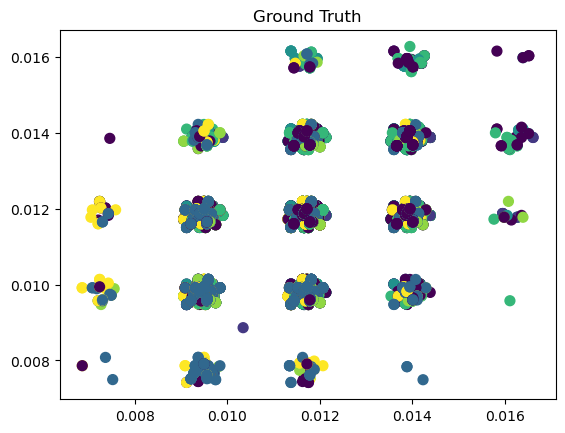

In [2]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

data_path, gt_path, data_name, gt_name = '/Users/aryamantepal/Desktop/Tufts2024/data/SalinasA_corrected.mat', '/Users/aryamantepal/Desktop/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'
X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)

print(GT.shape)

print(X.shape)
# kde = KernelDensity(bandwidth=1.0).fit(X)
# log_density = kde.score_samples(X)
# p = np.exp(log_density)
# print(p.shape)

# graph_extractor = GraphExtractor(sigma = 0.004250000000000, DiffusionNN = 75, NEigs=7138)
# G = graph_extractor.extract_graph(X)


# print(GT.shape, "This is GT")

# C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 150, G, p)

# GT = GT.astype(int)
# C = C.astype(int)
# accuracy = calculate_aligned_accuracy(GT, C)
# print("Aligned Accuracy:", accuracy)

# plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")